/tmp/ipython-input-1391596190.py:42: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, _ = quad(


Fitted Δ(0) = 1.106 meV,  A = 0.1781


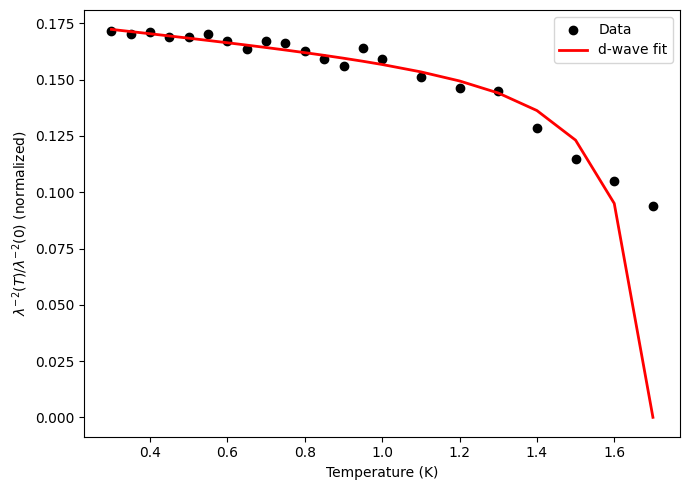

In [10]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# ===== Constants =====
kB = 8.617333262e-5  # eV/K

# ===== Gap symmetry: d-wave g(phi) = |cos(2φ)| =====
def g_phi(phi):
    return np.abs(np.cos(2 * phi))

# ===== Superconducting gap Δ(φ,T) =====
def Delta(phi, T, Delta0, Tc):
    if T >= Tc:
        return 0.0
    t = Tc / T - 1.0
    temp_factor = np.tanh(1.82 * (1.018 * t) ** 0.51)
    return Delta0 * g_phi(phi) * temp_factor

# ===== Integrand =====
def integrand_E(E, phi, T, Delta0, Tc):
    delta = Delta(phi, T, Delta0, Tc)
    if E < delta or delta == 0:
        return 0.0
    f = 1 / (1 + np.exp(E / (kB * T)))
    df_dE = -f * (1 - f) / (kB * T)
    return (E * df_dE) / np.sqrt(E**2 - delta**2)

# ===== λ^-2(T)/λ^-2(0) =====
def lambda_ratio(T, Delta0, Tc, Nphi=200):
    if T >= Tc:
        return 0.0
    phi_vals = np.linspace(0, 2 * np.pi, Nphi)
    integral_phi = 0.0
    # finite energy cutoff
    E_max = 20 * kB * Tc
    for phi in phi_vals:
        delta = Delta(phi, T, Delta0, Tc)
        if delta <= 0:
            continue
        val, _ = quad(
            integrand_E,
            delta,
            E_max,
            args=(phi, T, Delta0, Tc),
            epsabs=1e-7,
            epsrel=1e-5,
            limit=100,
        )
        integral_phi += val
    # average over φ
    return 1.0 + (1 / np.pi) * integral_phi * (2 * np.pi / Nphi)

# ===== Model for fitting =====
def model(T, Delta0, A):
    Tc = 1.7  # fixed experimentally
    return A * np.array([lambda_ratio(Ti, Delta0, Tc) for Ti in T])

# ===== Experimental data =====
Tdata = np.array([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75,
                  0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5,
                  1.6, 1.7])
ydata = np.array([0.1718, 0.1701, 0.1712, 0.169, 0.1691, 0.1704, 0.1673,
                  0.1635, 0.167, 0.1665, 0.1627, 0.159, 0.1563, 0.1642,
                  0.1594, 0.1511, 0.1465, 0.145, 0.1286, 0.1148, 0.105,
                  0.094])

# ===== Fit =====
# Initial guess: Δ0 ≈ 3e-4 eV (~0.3 meV), A ≈ average amplitude
popt, pcov = curve_fit(model, Tdata, ydata, p0=[3e-4, 0.17])
Delta_fit, A_fit = popt
print(f"Fitted Δ(0) = {Delta_fit*1e3:.3f} meV,  A = {A_fit:.4f}")

# ===== Plot =====
plt.figure(figsize=(7, 5))
plt.scatter(Tdata, ydata, label="Data", color="black")
plt.plot(Tdata, model(Tdata, *popt), color="red", lw=2, label="d-wave fit")
plt.xlabel("Temperature (K)")
plt.ylabel(r"$\lambda^{-2}(T)/\lambda^{-2}(0)$ (normalized)")
plt.legend()
plt.tight_layout()
plt.show()
